In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

class Box2D:
    def __init__(self, x, y, yaw, corner_points=None, v=0.0):
        self.x0 = x
        self.y0 = y
        self.x = x
        self.y = y
        self.yaw = yaw
        self.corner_points = corner_points
        self.inflat_cpoints = []
        self.v = v
    def reset_xy(self):
        self.x = self.x0
        self.y = self.y0
        
    def update_once(self, dt):
        self.x += self.v*dt*math.cos(self.yaw)
        self.y += self.v*dt*math.sin(self.yaw)
    def inflation_obs(self, r):
        A = []
        for i in range(len(self.corner_points[0])-1):
            v1 = [self.corner_points[0, i], self.corner_points[1, i]]
            v2 = [self.corner_points[0, i+1], self.corner_points[1, i+1]]
            a = v2[0] - v1[0]
            b = v1[1] - v2[1]
            c = v1[1]*a+v1[0]*b
            inflat_c = -r*math.sqrt(a*a+b*b)+c
            A.append([a, b, inflat_c])
        pre_ind = -1
        for i in range(len(A)):
            a1, b1, c1 = A[pre_ind][1], A[pre_ind][0], A[pre_ind][2]
            a2, b2, c2 = A[i][1], A[i][0], A[i][2]
            x = (b2*c1-b1*c2)/(a1*b2-a2*b1)
            y = (a1*c2-a2*c1)/(a1*b2-a2*b1)  
            self.inflat_cpoints.append([x, y])
            pre_ind = i
        self.inflat_cpoints.append(self.inflat_cpoints[0])   
        self.inflat_cpoints = np.array(self.inflat_cpoints).T
        
        
car_corner_points = np.array([[2.0, -2.0, -2.0, 2.0, 2.0],
                              [1.0, 1.0, -1.0, -1.0, 1.0]])
road_bound_points = np.array([[100.0, -15.0, -15.0, 100.0, 100.0],
                              [0.1, 0.1, -0.1, -0.1, 0.1]])


road_bound_left = Box2D(0.0, 3.5, 0.0, corner_points=road_bound_points)
road_bound_right = Box2D(0.0, -3.5, 0.0, corner_points=road_bound_points)

car1 = Box2D(1.0, 1.7, 0.0, corner_points=car_corner_points, v=0.0)
car2 = Box2D(20.0, -1.7, 0.0, corner_points=car_corner_points, v=0.0)
car3 = Box2D(45.0, 1.7, 0.0, corner_points=car_corner_points, v=0.0)
ego = Box2D(0.0, -1.7, 0.0, corner_points=car_corner_points, v=0.0)
obs_buf = [road_bound_left, road_bound_right, car1, car2, car3]
for obs in obs_buf:
    obs.inflation_obs(1.4)
    
def local2global(x0, y0, yaw0, corner_points):
    R = np.array([[math.cos(yaw0), -math.sin(yaw0)],
                  [math.sin(yaw0), math.cos(yaw0)]])
    corner_arr = np.array(corner_points)
    return np.dot(R, corner_arr)+np.array([[x0],[y0]])


def finding_convex_hull(ox, oy, x, y): # x: F集合中所有点的X值列表， y: F集合中所有点的Y值列表， 例如 p1=(x[1], y[1])
    # find the max r point as the first convex hull vertex
    ch_indexs = [np.argmax(np.sqrt((x-ox)**2+(y-oy)**2))] # 选择距离原点最远的点作为第一个凸包顶点
    while True:
        x0, y0 = x[ch_indexs[-1]], y[ch_indexs[-1]] # 以上一循环找到的凸包顶点作为当前向量的起点
        dpx, dpy = x - x0, y - y0 # pa到所有点形成的向量
        for i in range(len(x)): # 对翻转点集C进行遍历，直到找到下一个凸包顶点，退出
            if i == ch_indexs[-1]: continue # 当遍历到的点为上一个凸包顶点，则跳过
            abx, aby = dpx[i], dpy[i] # 检测向量papb
            M = abx*dpy-aby*dpx # 计算向量papb与所有其它向量的叉乘
            if np.all(M>=0): # 若向量papb能保证没有任何点在它的右侧（可以在左侧或向量所在的直线上），则pi为当前找到的凸包顶点
                if i == ch_indexs[0]: # 若当前找到的顶点与第一个顶点相同，则说明顶点已经首尾相接形成凸包，退出循环，返回凸包顶点
                    ch_indexs.append(ch_indexs[0]) # 这一行使得头和尾都为p0，只是为了后续处理更加方便
                    return ch_indexs
                ch_indexs.append(i)
                break


MAP_lines = []
MAP_cars = []
for obs in obs_buf:
    gcp0 = local2global(obs.x, obs.y, obs.yaw, obs.inflat_cpoints)
    for j in range(len(gcp0[0])-1):
        MAP_lines.append([gcp0[0][j], gcp0[1][j], gcp0[0][j+1], gcp0[1][j+1]])      
    
    gcp_car = local2global(obs.x, obs.y, obs.yaw, obs.corner_points)
    for j in range(len(gcp_car[0])-1):
        MAP_cars.append([gcp_car[0][j], gcp_car[1][j], gcp_car[0][j+1], gcp_car[1][j+1]])          

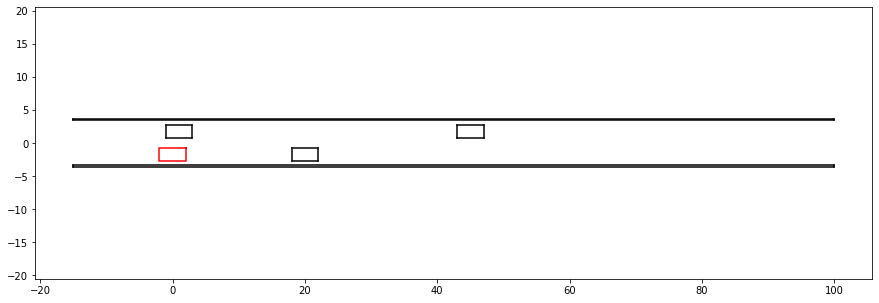

In [3]:
plt.figure(figsize=(15,5)) 
ego_cps = local2global(ego.x, ego.y, ego.yaw, ego.corner_points)
plt.plot(ego_cps[0], ego_cps[1], 'r')
for line in MAP_cars:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
plt.axis('equal')    
plt.show()

In [11]:
# time cost is 0.05774664878845215
def line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
    if ((max(Ax1,Ax2)<=min(Bx1,Bx2) or min(Ax1,Ax2)>=max(Bx1,Bx2)) or
        (max(Ay1,Ay2)<=min(By1,By2) or min(Ay1,Ay2)>=max(By1,By2))):
        return False
    if (((Bx1-Ax1)*(Ay2-Ay1)-(By1-Ay1)*(Ax2-Ax1))*((Bx2-Ax1)*(Ay2-Ay1)-(By2-Ay1)*(Ax2-Ax1))<0 and
        ((Ax1-Bx1)*(By2-By1)-(Ay1-By1)*(Bx2-Bx1))*((Ax2-Bx1)*(By2-By1)-(Ay2-By1)*(Bx2-Bx1))<0):
        return True
    return False

def point_in_obs_judge(p, A):
    A_mat = np.array(A)
    x = np.array([p[1], p[0], -1]).T
    M = np.dot(A_mat, x)
    if np.min(M) > 0:
        return True
    return False

In [5]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.cost = 0
        self.parent = -1

start_pos = [0.0, -1.7]
desired_l = -1.7
N_step = 20
ds = 5.0
L_num = 5
barr_right = -2.0
barr_left = 2.0
sample_nodes = [[] for i in range(N_step)]
sample_nodes[0].append(Node(start_pos[0], start_pos[1]))

for i in range(1, N_step):
    for l in np.concatenate((np.linspace(barr_right, barr_left, L_num), [0.0])):
        sample_nodes[i].append(Node(i*ds, l))    

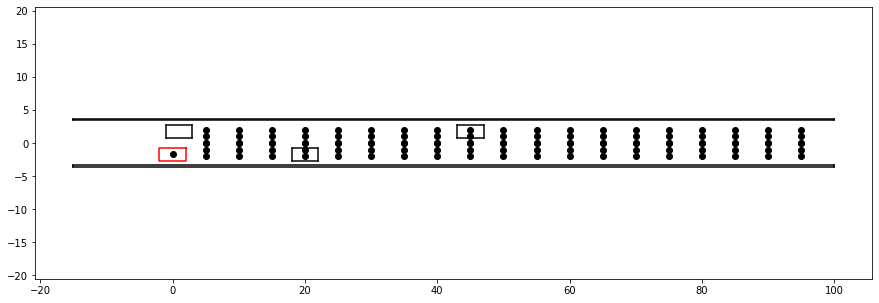

In [6]:
plt.figure(figsize=(15,5)) 
ego_cps = local2global(ego.x, ego.y, ego.yaw, ego.corner_points)
plt.plot(ego_cps[0], ego_cps[1], 'r')
for line in MAP_cars:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')


for nodes in sample_nodes:
    for n in nodes:
        plt.scatter(n.x, n.y, color='k')
        
plt.axis('equal')    
plt.show()        

In [13]:
def check_collision(n0, n1):
    Ax1, Ay1 = n0.x, n0.y
    Ax2, Ay2 = n1.x, n1.y
    for line in MAP_lines:            
        Bx1, By1, Bx2, By2 = line
        if line_segment_cross_judge(Ax1, Ay1, Ax2, Ay2, Bx1, By1, Bx2, By2):
            return False
    return True 

def calculate_cost(n0, n1):
    if check_collision(n0, n1):
        dx = n0.x - n1.x
        dy = n0.y - n1.y
        d_cost = np.sqrt(dx*dx + dy*dy)
        l_cost = abs(n1.y - desired_l)
        return 0.4*d_cost+0.6*l_cost        
    else: return 9999.0
    

for i in range(N_step - 1):
    for n0 in sample_nodes[N_step - i - 2]:
        n0.cost = 99999.0
        min_cost = 99999.0
        for k, n1 in enumerate(sample_nodes[N_step - i - 1]):
            cost = calculate_cost(n0, n1) + n1.cost
            print("cost: "+str(cost))
            if min_cost > cost:
                min_cost = cost
                n0.cost = min_cost
                n0.parent = k

cost: 2.18
cost: 2.459607805437114
cost: 3.1740659228538015
cost: 3.9523807579381205
cost: 4.781249694973139
cost: 3.1740659228538015
cost: 2.2196078054371142
cost: 2.42
cost: 3.059607805437114
cost: 3.7740659228538016
cost: 4.552380757938121
cost: 3.059607805437114
cost: 2.3340659228538017
cost: 2.459607805437114
cost: 3.02
cost: 3.659607805437114
cost: 4.374065922853802
cost: 3.02
cost: 2.5123807579381205
cost: 2.5740659228538014
cost: 3.059607805437114
cost: 3.62
cost: 4.259607805437114
cost: 3.059607805437114
cost: 2.7412496949731397
cost: 2.7523807579381203
cost: 3.1740659228538015
cost: 3.659607805437114
cost: 4.220000000000001
cost: 3.1740659228538015
cost: 2.3340659228538017
cost: 2.459607805437114
cost: 3.02
cost: 3.659607805437114
cost: 4.374065922853802
cost: 3.02
cost: 4.36
cost: 4.679215610874229
cost: 5.508131845707603
cost: 6.464761515876241
cost: 7.5224993899462795
cost: 5.508131845707603
cost: 4.399607805437114
cost: 4.639607805437114
cost: 5.393673728290915
cost: 6.28

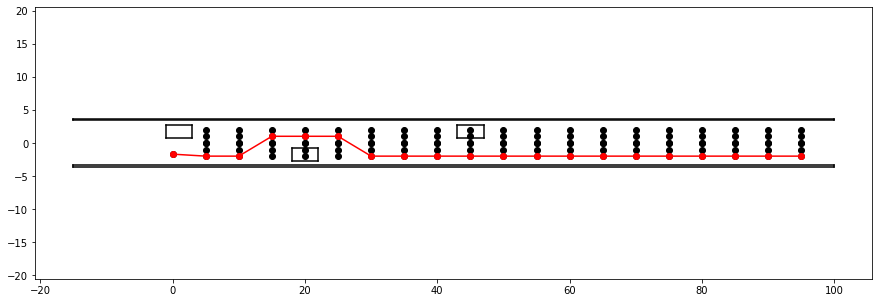

In [14]:
plt.figure(figsize=(15,5)) 
for line in MAP_cars:
    plt.plot([line[0], line[2]], [line[1], line[3]], 'k')
for nodes in sample_nodes:
    for n in nodes:
        plt.scatter(n.x, n.y, color='k')
child_idx = 0
path = []
for i in range(N_step):    
    plt.scatter(sample_nodes[i][child_idx].x, sample_nodes[i][child_idx].y, color='red')
    path.append([sample_nodes[i][child_idx].x, sample_nodes[i][child_idx].y])
    child_idx = sample_nodes[i][child_idx].parent
    
plt.plot(np.array(path)[:,0], np.array(path)[:,1], 'r')
plt.axis('equal')    
plt.show()

0
1
2
3
4
5
6
7
8
9
